In [40]:
import os

import torch
import wandb
import sys
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import pandas as pd
import numpy as np
from torchmetrics.classification import BinaryF1Score
from torchmetrics import Dice

# Add the parent directory to sys.path
sys.path.append(os.path.dirname(os.path.realpath(os.path.abspath(""))))

from unet.dataset import DeadwoodDataset
from unet.dice_score import dice_coeff, confusion_values
from unet.evaluate import evaluate
from unet.unet_model import UNet

In [2]:
# import importlib
# importlib.reload(sys.modules['unet.dice_score'])

In [3]:
# data paths
register_file = "/net/scratch/jmoehring/tiles_register_biome.csv"
checkpoint_dir = "/net/scratch/jmoehring/checkpoints"
model_checkpoint = "deadwood_tyrannis-lucern-esterization_fold_0_epoch_7.pth"

# data params
no_folds: int = 5
fold: int = 0
val_percent: float = 0.1
random_seed: int = 42
batch_size: int = 32

In [4]:
dataset = DeadwoodDataset(
    register_file=register_file,
    n_folds=no_folds,
    random_seed=random_seed,
)

In [5]:
register_df = pd.read_csv(register_file)

In [6]:
register_df.head()

,base_file_name,file_path,resolution,x,y,label_quality,biome
0,uavforsat_2017_CFB141_ortho.tif,/net/scratch/jmoehring/tiles/uavforsat_2017_CF...,0.14,577,342,3.0,4.0
1,uavforsat_2017_CFB141_ortho.tif,/net/scratch/jmoehring/tiles/uavforsat_2017_CF...,0.14,374,545,3.0,4.0
2,uavforsat_2017_CFB141_ortho.tif,/net/scratch/jmoehring/tiles/uavforsat_2017_CF...,0.14,374,342,3.0,4.0
3,uavforsat_2017_CFB141_ortho.tif,/net/scratch/jmoehring/tiles/uavforsat_2017_CF...,0.14,577,545,3.0,4.0
4,uavforsat_2017_CFB141_ortho.tif,/net/scratch/jmoehring/tiles/uavforsat_2017_CF...,0.20,250,228,3.0,4.0


<Axes: >

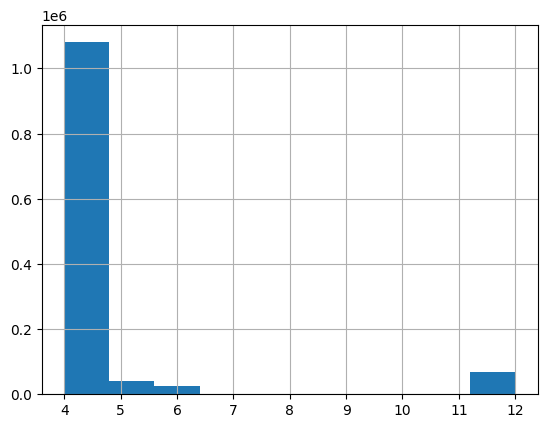

In [7]:
register_df["biome"].hist()

In [8]:
# get test fold
_, val_indices = dataset.get_fold(fold)
val_set = Subset(dataset, val_indices)

In [9]:
loader_args = {
    "batch_size": batch_size,
    "num_workers": 12,
    "pin_memory": True,
    "shuffle": True,
}
val_loader = DataLoader(val_set, **loader_args)

In [10]:
# preferably use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model with three input channels (RGB)
model = UNet(n_channels=3, n_classes=1, bilinear=True)
model.load_state_dict(torch.load(os.path.join(checkpoint_dir, model_checkpoint)))
model = model.to(memory_format=torch.channels_last, device=device)
model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [11]:
# run = "deadwood_tyrannis-lucern-esterization_fold_0_epoch_7_test_biome_heatmap"
# wandb.init(project="standing-deadwood-unet", name=run, resume=False)

In [12]:
register_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215181 entries, 0 to 1215180
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   base_file_name  1215181 non-null  object 
 1   file_path       1215181 non-null  object 
 2   resolution      1215181 non-null  float64
 3   x               1215181 non-null  int64  
 4   y               1215181 non-null  int64  
 5   label_quality   1193120 non-null  float64
 6   biome           1215181 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 64.9+ MB


In [51]:
result = {
    "f1": [],
    "dice_score": [],
    "precision": [],
    "recall": [],
    "file_path": [],
}

for batch, (images, true_masks, images_metas) in tqdm(
    enumerate(val_loader), total=len(val_loader)
):
    images = images.to(memory_format=torch.channels_last, device=device)
    true_masks = true_masks.to(memory_format=torch.channels_last, device=device)
    with torch.no_grad():
        pred_masks = model(images)
        pred_masks = torch.sigmoid(pred_masks)
        pred_masks_sig = (pred_masks > 0.5).float()

        f1_new = BinaryF1Score().to(device)
        f1_value = f1_new(pred_masks_sig, true_masks)
        print(f1_value)
        dice_new = Dice().to(device)
        dice_value = dice_new(pred_masks_sig, true_masks)
        print(dice_value)

        conf_values = confusion_values(pred_masks_sig, true_masks)
        dice_score = dice_coeff(pred_masks_sig, true_masks)

        result["dice_score"].append(dice_score.item())
        result["f1"].extend(conf_values["f1"].squeeze().tolist())
        result["precision"].extend(conf_values["precision"].squeeze().tolist())
        result["recall"].extend(conf_values["recall"].squeeze().tolist())
        result["file_path"].extend(images_metas["file_path"])
        break

  0%|          | 0/8378 [00:01<?, ?it/s]

tensor(0.5824, device='cuda:0')
tensor(0.5824, device='cuda:0')


In [24]:
result["dice_score"]

[0.7463526129722595]

In [53]:
register_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215181 entries, 0 to 1215180
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   base_file_name  1215181 non-null  object 
 1   file_path       1215181 non-null  object 
 2   resolution      1215181 non-null  float64
 3   x               1215181 non-null  int64  
 4   y               1215181 non-null  int64  
 5   label_quality   1193120 non-null  float64
 6   biome           1215181 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 64.9+ MB


In [25]:
result_df = pd.DataFrame.from_dict(result, orient="index").T

In [15]:
result_df.to_csv("/net/scratch/jmoehring/confusion_register_new.csv", index=False)